### PyTorch custom Datasets

### Importing PyTorch and setting up device-agnostic code

In [3]:
import torch
from torch import nn

torch.__version__

'2.1.1+cu121'

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!nvidia-smi

Tue Jan 23 18:15:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        Off | 00000000:01:00.0  On |                  N/A |
| N/A   33C    P5               8W /  50W |     57MiB /  4096MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import requests
import zipfile
from pathlib import Path

# setup path to a data loader
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Downloading pizza steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak and sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


### Becoming  one with the data (data preparation and data exploration)

In [1]:
import os
def walk_through_dir(dir_path):
    """ walks through dir_path returning all its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing an image

Here we write some code to do the follwoing:
1. Get all of the image paths
2. Pick a random image path using pythons random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let;s open the iamge with Python's PIL
5. We'll then show the image and print the metadata

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

#### First using the PIL Library

Random Image Path: data/pizza_steak_sushi/train/steak/231296.jpg
Image class: steak
Image Height: 382
Image width: 512


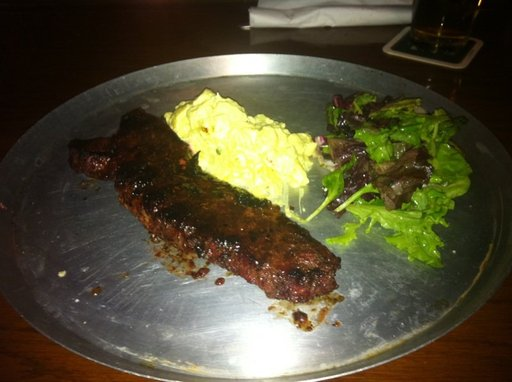

In [23]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path from image_path_list
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# Get the image class from the  path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# print(image_class)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image width: {img.width}")

img

#### Then, using Matplotlib

(-0.5, 511.5, 381.5, -0.5)

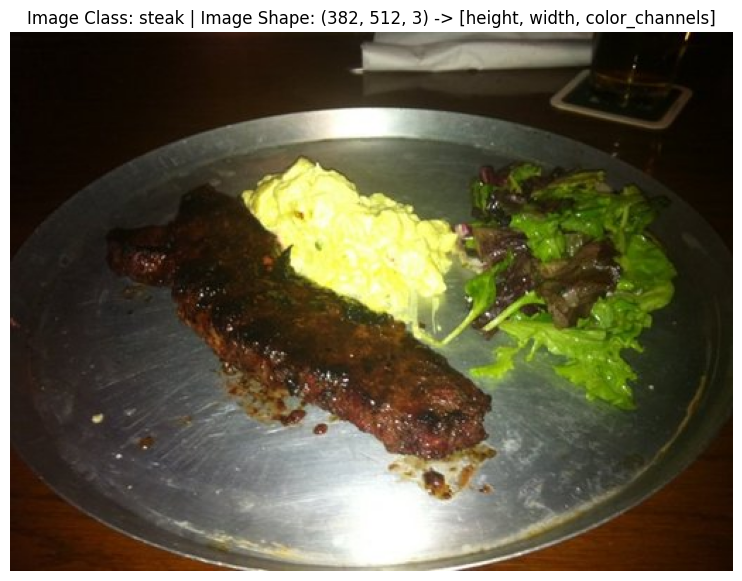

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Pliot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)

plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

`Matplotlib` and `PIL` defaults to color channels last [H, W, C], whereas `PyTorch` defaults to color channels first [C, H, W]

### Transforming Data

Before we can use our imahe data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these as `Dataset` and `DataLoader` for short

In [25]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`
Transforms help you get your images readay to be used with a model/perform data augmentation

In [26]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the images into torch.Tensor
    transforms.ToTensor()
])

In [31]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

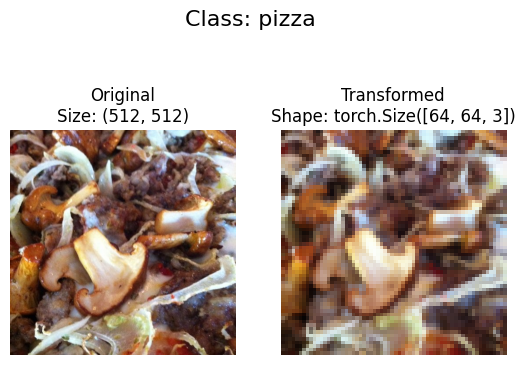

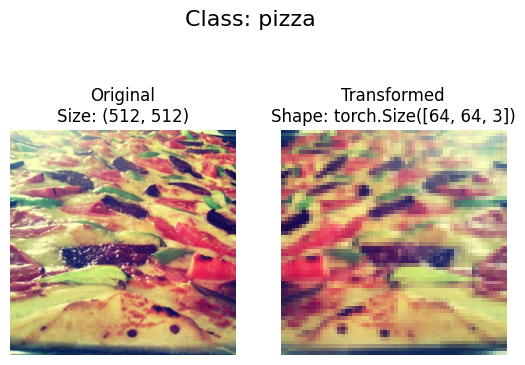

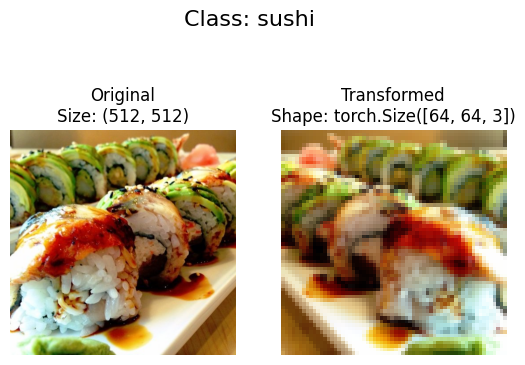

In [34]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Seletcts random images from a path of images and loads/transforms them 
    then plots the original vs the transformed version.
    """

    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)


            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # Note: we will need to change shape for Matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

### Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`

In [35]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [36]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [37]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [39]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)